In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales/Walmart_Sales.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
import sklearn, xgboost, statsmodels, joblib, keras
print("sklearn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("statsmodels:", statsmodels.__version__)
print("joblib:", joblib.__version__)
print("keras:", keras.__version__)
print("numpy:", np.__version__)
print("pandas", pd.__version__)

sklearn: 1.2.2
xgboost: 2.0.3
statsmodels: 0.14.2
joblib: 1.4.2
keras: 3.3.3
numpy: 1.26.4
pandas 2.2.2


# Load Data

In [3]:
data = pd.read_csv("/kaggle/input/walmart-sales/Walmart_Sales.csv")
data 

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


# Data Understanding 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Count how many records each store has
store_counts = data['Store'].value_counts().sort_index()

# Get the min and max date for each store
store_date_range = data.groupby('Store')['Date'].agg(['min', 'max'])

# Check if all store counts are the same
if store_counts.nunique() == 1:
    print(f"All stores have {store_counts.iloc[0]} records.")

# Check if all stores have the same date range
if store_date_range.nunique().nunique() == 1:
    print(f"All stores have the dates ranging from {store_date_range['min'].iloc[0]} to {store_date_range['max'].iloc[0]}.")


All stores have 143 records.
All stores have the dates ranging from 2010-02-05 00:00:00 to 2012-10-26 00:00:00.


# Data Preprocessing

## Index Date for Timeseries 

In [5]:
# data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y') # Converts to year-month-day standard format as datetime type
data.set_index('Date', inplace=True)
data = data.sort_index()
data

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-05,10,2193048.75,0,54.34,2.962,126.442065,9.765
2010-02-05,37,536006.73,0,45.97,2.572,209.852966,8.554
2010-02-05,17,789036.02,0,23.11,2.666,126.442065,6.548
2010-02-05,30,465108.52,0,39.05,2.572,210.752605,8.324
...,...,...,...,...,...,...,...
2012-10-26,25,688940.94,0,56.69,3.882,216.151590,7.293
2012-10-26,5,319550.77,0,71.70,3.506,224.037814,5.422
2012-10-26,40,921264.52,0,49.65,3.917,138.728161,4.145


In [38]:
# Access all rows for a specific date
selected_date_data = data.loc['2010-02-05']
selected_date_data

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-05,2,2136989.46,0,40.19,2.572,210.752605,8.324
2010-02-05,3,461622.22,0,45.71,2.572,214.424881,7.368
2010-02-05,4,2135143.87,0,43.76,2.598,126.442065,8.623
2010-02-05,5,317173.10,0,39.70,2.572,211.653972,6.566
2010-02-05,6,1652635.10,0,40.43,2.572,212.622352,7.259
2010-02-05,7,496725.44,0,10.53,2.580,189.381697,9.014
2010-02-05,8,1004137.09,0,34.14,2.572,214.471451,6.299
2010-02-05,9,549505.55,0,38.01,2.572,214.655459,6.415


## EDA 

### Ranking Sales  

In [37]:
# Group by Store and calculate total sales
store_sales = data.groupby('Store')['Weekly_Sales'].sum().reset_index()

# Sort the stores by total sales in descending order
store_sales = store_sales.sort_values(by='Weekly_Sales', ascending=False)

# Display the top performing stores
print("Top Performing Weekly Sales")
print(store_sales.head())

# Group by Store and calculate average weekly sales
store_avg_sales = data.groupby('Store')['Weekly_Sales'].mean().reset_index()

# Sort the stores by average sales in descending order
store_avg_sales = store_avg_sales.sort_values(by='Weekly_Sales', ascending=False)

# Display the top performing stores based on average sales
print("Average Weekly Sales")
print(store_avg_sales.head())

# Get row of top performing store
top_store_index = store_sales.index[0]
top_store_number = store_avg_sales.loc[top_store_index, 'Store'] 
top_store_data = data[data['Store'] == top_store_number]
top_store_data.head()

Top Performing Weekly Sales
    Store  Weekly_Sales
19     20  3.013978e+08
3       4  2.995440e+08
13     14  2.889999e+08
12     13  2.865177e+08
1       2  2.753824e+08
Average Weekly Sales
    Store  Weekly_Sales
19     20  2.107677e+06
3       4  2.094713e+06
13     14  2.020978e+06
12     13  2.003620e+06
1       2  1.925751e+06


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,20,2401395.47,0,25.92,2.784,204.247194,8.187
2010-02-12,20,2109107.90,1,22.12,2.773,204.385747,8.187
2010-02-19,20,2161549.76,0,25.43,2.745,204.432100,8.187
2010-02-26,20,1898193.95,0,32.32,2.754,204.463087,8.187
2010-03-05,20,2119213.72,0,31.75,2.777,204.494073,8.187


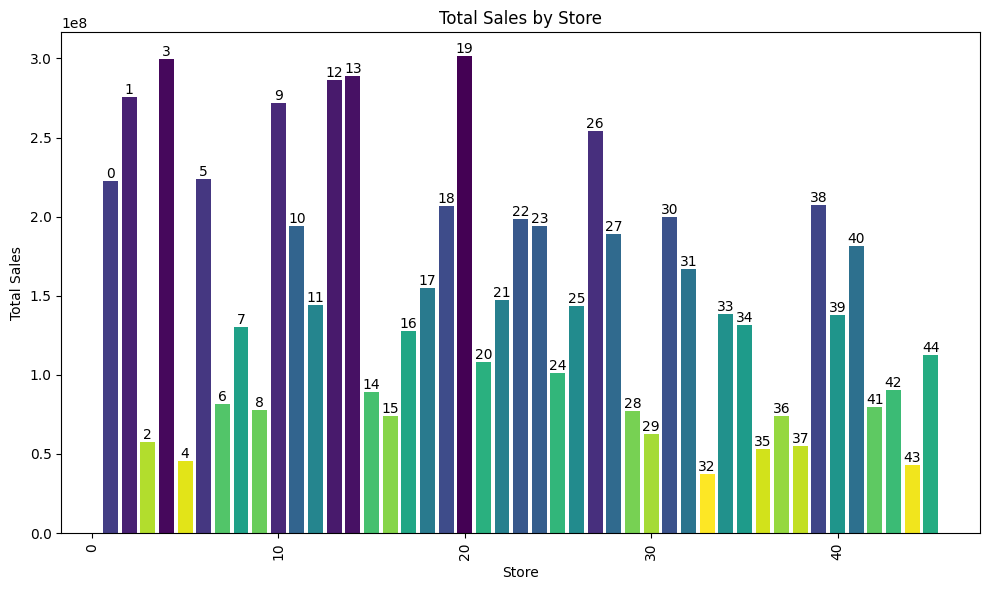

In [29]:
# Random color generation for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(store_sales)))

# Create the bar plot with different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(store_sales['Store'], store_sales['Weekly_Sales'], color=colors)

# Add store number as labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(bar.get_x()), ha='center', va='bottom')

# Label the axes and the title
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store')

# Rotate the x-ticks for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

### Weekly Sales over Time per Store

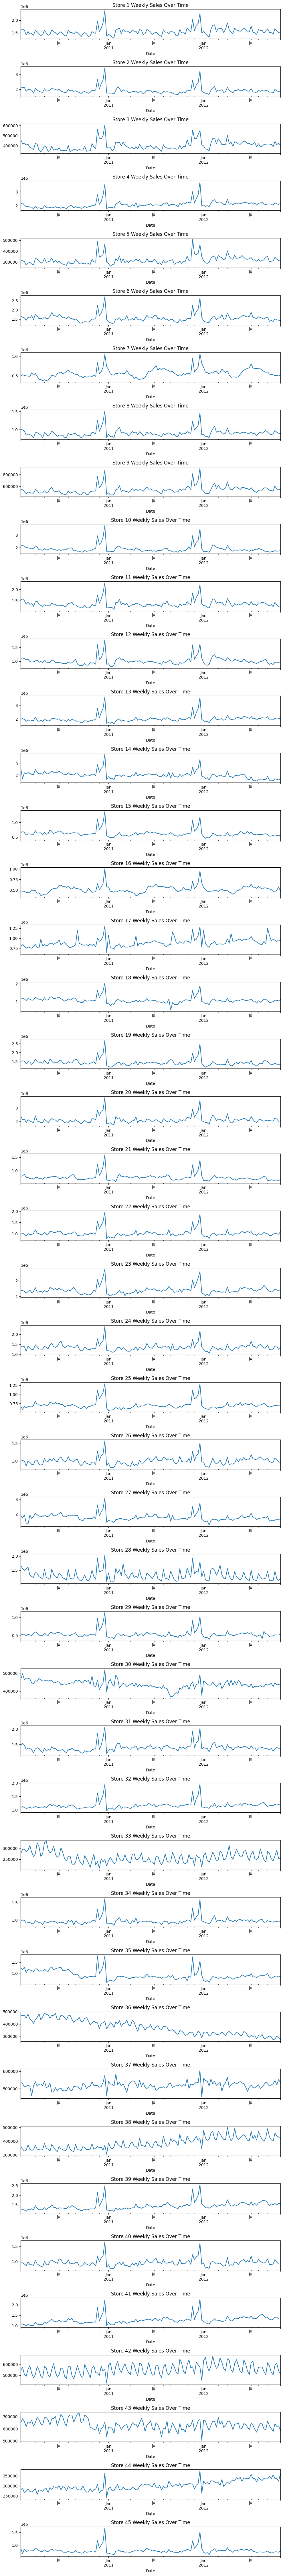

In [19]:
stores = data['Store'].unique()
# stores_to_plot = [1, 2, 3, 4]  
fig, axes = plt.subplots(len(stores), 1, figsize=(10, len(unique_stores) * 2))

for i, store in enumerate(stores):
    store_data = data[data['Store'] == store]
    store_data['Weekly_Sales'].plot(ax=axes[i], title=f'Store {store} Weekly Sales Over Time')

plt.tight_layout()
plt.show()

### Correlation Heatmap between Features

Text(0.5, 1.0, 'Correlation Between Features')

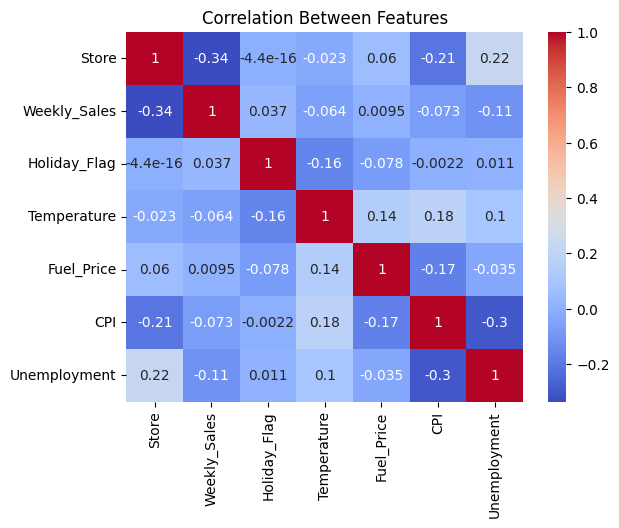

In [17]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features')

## Feature Engineering Lag Features for Weekly Sales for each Store

* Lagged features capture temporal dependencies in timeseries adding time context for regression models 

In [6]:
# Lag 1 week - shift the sales column by 1 week for each store
data['Lag_1_Week_Sales'] = data.groupby('Store')['Weekly_Sales'].shift(1)

# Lag 2 weeks - shift the sales column by 2 weeks for each store
data['Lag_2_Week_Sales'] = data.groupby('Store')['Weekly_Sales'].shift(2)

# Fill null lagged values with the previous value 
data.bfill(inplace=True)

## Feature engineering time context from date index

In [7]:
# Feature engineering from the date index to add time context 
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['WeekOfYear'] = data.index.isocalendar().week
data['Year'] = data.index.year

In [17]:
data

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Lag_1_Week_Sales,Lag_2_Week_Sales,DayOfWeek,Month,WeekOfYear,Year
Date,,,,,,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,1004137.09,890689.51,4,2,5,2010
2010-02-05,10,2193048.75,0,54.34,2.962,126.442065,9.765,1004137.09,890689.51,4,2,5,2010
2010-02-05,37,536006.73,0,45.97,2.572,209.852966,8.554,1004137.09,890689.51,4,2,5,2010
2010-02-05,17,789036.02,0,23.11,2.666,126.442065,6.548,1004137.09,890689.51,4,2,5,2010
2010-02-05,30,465108.52,0,39.05,2.572,210.752605,8.324,1004137.09,890689.51,4,2,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,25,688940.94,0,56.69,3.882,216.151590,7.293,685531.85,697317.41,4,10,43,2012
2012-10-26,5,319550.77,0,71.70,3.506,224.037814,5.422,313358.15,325345.41,4,10,43,2012
2012-10-26,40,921264.52,0,49.65,3.917,138.728161,4.145,918170.50,982523.26,4,10,43,2012


## One-Hot Encoding store numbers 

In [8]:
# One-hot encode store numbers
data = pd.get_dummies(data, columns=['Store'])
data = data.astype(int) # Convert boolean to binary value

In [9]:
data

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Lag_1_Week_Sales,Lag_2_Week_Sales,DayOfWeek,Month,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1643690,0,42,2,211,8,1004137,890689,4,2,...,0,0,0,0,0,0,0,0,0,0
2010-02-05,2193048,0,54,2,126,9,1004137,890689,4,2,...,0,0,0,0,0,0,0,0,0,0
2010-02-05,536006,0,45,2,209,8,1004137,890689,4,2,...,0,1,0,0,0,0,0,0,0,0
2010-02-05,789036,0,23,2,126,6,1004137,890689,4,2,...,0,0,0,0,0,0,0,0,0,0
2010-02-05,465108,0,39,2,210,8,1004137,890689,4,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,688940,0,56,3,216,7,685531,697317,4,10,...,0,0,0,0,0,0,0,0,0,0
2012-10-26,319550,0,71,3,224,5,313358,325345,4,10,...,0,0,0,0,0,0,0,0,0,0
2012-10-26,921264,0,49,3,138,4,918170,982523,4,10,...,0,0,0,0,1,0,0,0,0,0


In [10]:
data.columns

Index(['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Lag_1_Week_Sales', 'Lag_2_Week_Sales', 'DayOfWeek',
       'Month', 'WeekOfYear', 'Year', 'Store_1', 'Store_2', 'Store_3',
       'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9',
       'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15',
       'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21',
       'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27',
       'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33',
       'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45'],
      dtype='object')

## Normalisation 

In [63]:
df_train = data.copy()
features = data.columns
# features = data.columns.difference(['Weekly_Sales'])

minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(df_train[features])
df_train[features] = minmax_scaled_data
df_train

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Lag_1_Week_Sales,Lag_2_Week_Sales,DayOfWeek,Month,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.397291,0.0,0.431373,0.0,0.841584,0.454545,0.220066,0.188628,0.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-05,0.549523,0.0,0.549020,0.0,0.000000,0.545455,0.220066,0.188628,0.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-05,0.090343,0.0,0.460784,0.0,0.821782,0.454545,0.220066,0.188628,0.0,0.090909,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-05,0.160459,0.0,0.245098,0.0,0.000000,0.272727,0.220066,0.188628,0.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-05,0.070696,0.0,0.401961,0.0,0.831683,0.454545,0.220066,0.188628,0.0,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,0.132722,0.0,0.568627,0.5,0.891089,0.363636,0.131777,0.135043,0.0,0.818182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-26,0.030361,0.0,0.715686,0.5,0.970297,0.181818,0.028645,0.031967,0.0,0.818182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-26,0.197101,0.0,0.500000,0.5,0.118812,0.090909,0.196244,0.214076,0.0,0.818182,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Training

## Tree-Based Models

In [34]:
# Train-test split
features = [col for col in data.columns if col != 'Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(
    data[features],
    data['Weekly_Sales'], 
    test_size=0.2, 
    shuffle=False
)

### XGBoost Regressor

In [35]:
# Initialize and train XGBoost
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Save model
# joblib.dump(model, 'xgboost_model.pkl')
# joblib.dump(model, 'xgboost_model.joblib')
# model.save_model('xgboost_model.json')

In [40]:
print(len(y_test))

1287


### Random Forest Regressor

In [ ]:
# Initialize and train the RandomForest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Make predictions
predictions_rf = model_rf.predict(X_test)

# Save model 
# joblib.dump(model_rf, 'randomforest_model.pkl')
joblib.dump(model, 'randomforest_model.joblib')

In [14]:
def evaluate_model(y_test, predictions):
    # Calculate mean of the actual weekly sales
    mean_sales = y_test.mean()
    print(f"Mean Weekly Sales: {mean_sales}")

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)
    print(f"MAE: {mae} ({(mae / mean_sales) * 100:.2f}% of the mean sales)")

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE: {mse}")

    # Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print(f"RMSE: {rmse} ({(rmse / mean_sales) * 100:.2f}% of the mean sales)")

    # R-squared (R²)
    r2 = r2_score(y_test, predictions)
    print(f"R-squared: {r2} ({r2 * 100:.2f}% of the variance in sales)")

    # Mean Absolute Percentage Error (MAPE)
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    mape = mean_absolute_percentage_error(y_test, predictions)
    print(f"MAPE: {mape}%")
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'MAPE': mape
    }

### Evaluation Metrics

In [16]:
# For XGBoost
xgboost_scores = evaluate_model(y_test, predictions)

# For RandomForest
random_forest_scores = evaluate_model(y_test, predictions_rf)

# Print out the dictionary values
print(f"XGBoost Scores: {xgboost_scores}")
print(f"Random Forest Scores: {random_forest_scores}")

Mean Weekly Sales: 1038073.9393939395
MAE: 46187.63983585859 (4.45% of the mean sales)
MSE: 4138757087.8830614
RMSE: 64333.172530841824 (6.20% of the mean sales)
R-squared: 0.9854292982247775 (98.54% of the variance in sales)
MAPE: 4.714610067009332%
Mean Weekly Sales: 1038073.9393939395
MAE: 50170.74921522921 (4.83% of the mean sales)
MSE: 5024624280.066645
RMSE: 70884.5842201719 (6.83% of the mean sales)
R-squared: 0.9823105583722865 (98.23% of the variance in sales)
MAPE: 5.091450900949527%
XGBoost Scores: {'MAE': 46187.63983585859, 'RMSE': 64333.172530841824, 'R-squared': 0.9854292982247775, 'MAPE': 4.714610067009332}
Random Forest Scores: {'MAE': 50170.74921522921, 'RMSE': 70884.5842201719, 'R-squared': 0.9823105583722865, 'MAPE': 5.091450900949527}


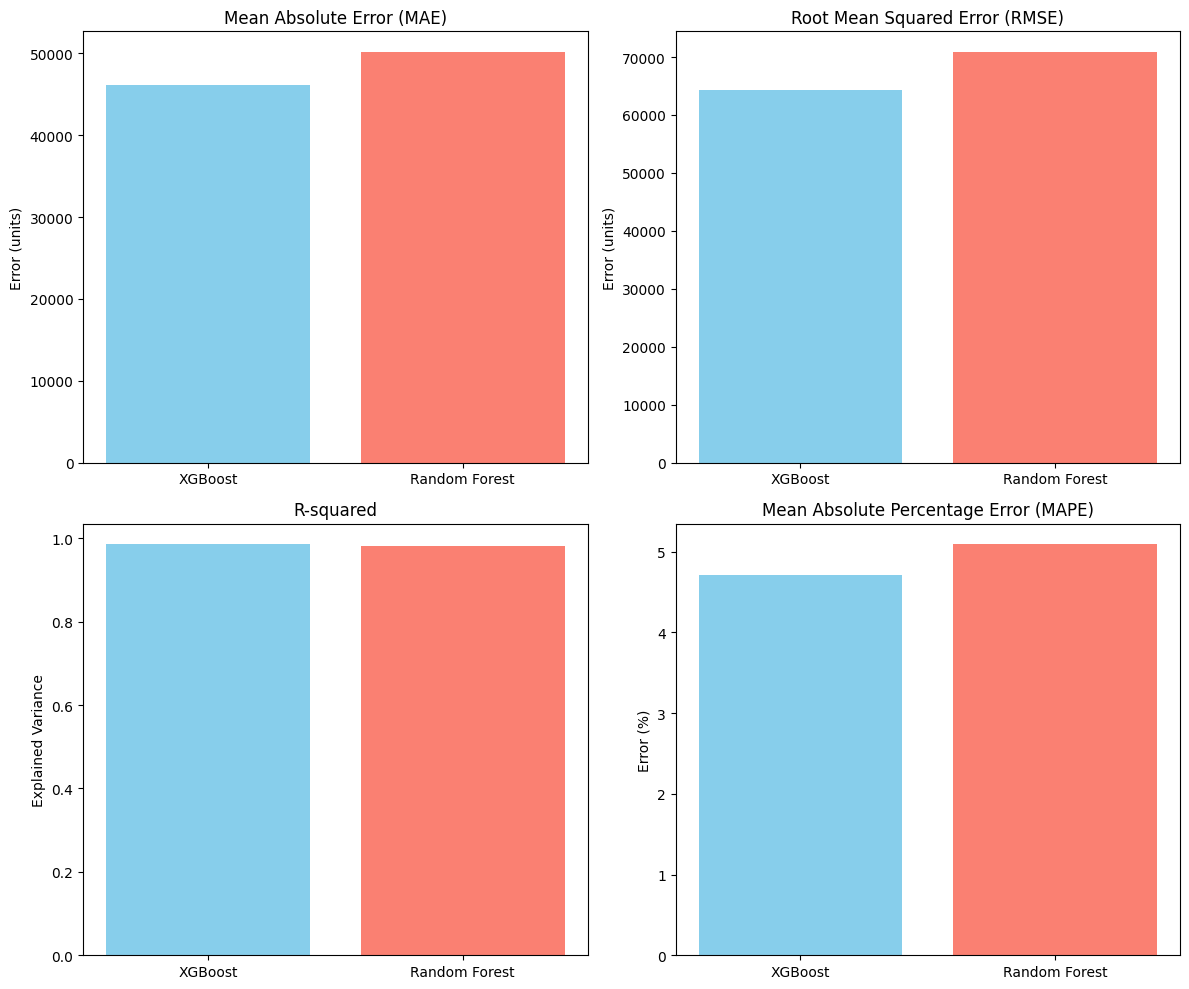

In [17]:
# Separate plots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  

# MAE plot
axes[0, 0].bar(['XGBoost', 'Random Forest'], 
               [xgboost_scores['MAE'], random_forest_scores['MAE']], 
               color=['skyblue', 'salmon'])
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('Error (units)')

# RMSE plot
axes[0, 1].bar(['XGBoost', 'Random Forest'], 
               [xgboost_scores['RMSE'], random_forest_scores['RMSE']], 
               color=['skyblue', 'salmon'])
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('Error (units)')

# R-squared plot
axes[1, 0].bar(['XGBoost', 'Random Forest'], 
               [xgboost_scores['R-squared'], random_forest_scores['R-squared']], 
               color=['skyblue', 'salmon'])
axes[1, 0].set_title('R-squared')
axes[1, 0].set_ylabel('Explained Variance')

# MAPE plot
axes[1, 1].bar(['XGBoost', 'Random Forest'], 
               [xgboost_scores['MAPE'], random_forest_scores['MAPE']], 
               color=['skyblue', 'salmon'])
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 1].set_ylabel('Error (%)')

# Adjust layout
plt.tight_layout()
plt.show()


## Hyperparameter Tuning

In [44]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Define the parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

# Initialize models
xgb_model = XGBRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# Grid search for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', verbose=3)
grid_search_xgb.fit(X_train, y_train)

# Grid search for RandomForest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error', verbose=3)
grid_search_rf.fit(X_train, y_train)

# Best models
best_xgb_model = grid_search_xgb.best_estimator_
best_rf_model = grid_search_rf.best_estimator_

# Predictions
predictions_xgb = best_xgb_model.predict(X_test)
predictions_rf = best_rf_model.predict(X_test)

# Average predictions
final_predictions = (predictions_xgb + predictions_rf) / 2

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-53719999023.829 total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-80997537996.320 total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-79051981768.986 total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-23066133424.194 total time=   0.3s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-37758674119.949 total time=   0.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-32828591778.380 total time=   0.3s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=-56310049084.798 total time=   0.3s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=-64958902454.055 total time=   0.3s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=-64346189948.

In [ ]:
joblib.dump(best_xgb_model, 'xgb_model-tuned.joblib')
joblib.dump(best_rf_model, 'rf_model-tuned.joblib')

In [49]:
print(f"y_test: {y_test}")
print(f"predictions_xgb: {predictions_xgb}")
print(f"predictions_rf: {predictions_rf}")
print(f"final_predictions: {final_predictions}")

y_test: Date
2012-04-13    1365098
2012-04-13     939118
2012-04-13    1621031
2012-04-13     857811
2012-04-13    2057637
               ...   
2012-10-26     688940
2012-10-26     319550
2012-10-26     921264
2012-10-26    1127516
2012-10-26     760281
Name: Weekly_Sales, Length: 1287, dtype: int64
predictions_xgb: [1469834.8 1067466.2 1726540.4 ...  906946.9 1065966.4  724359.5]
predictions_rf: [1518281.49231251 1014076.50861466 1800327.62466029 ...  933925.16226082
 1055507.65541983  730311.76685064]
final_predictions: [1494058.12115625 1040771.37930733 1763433.99983014 ...  920436.01863041
 1060737.01520991  727335.63342532]


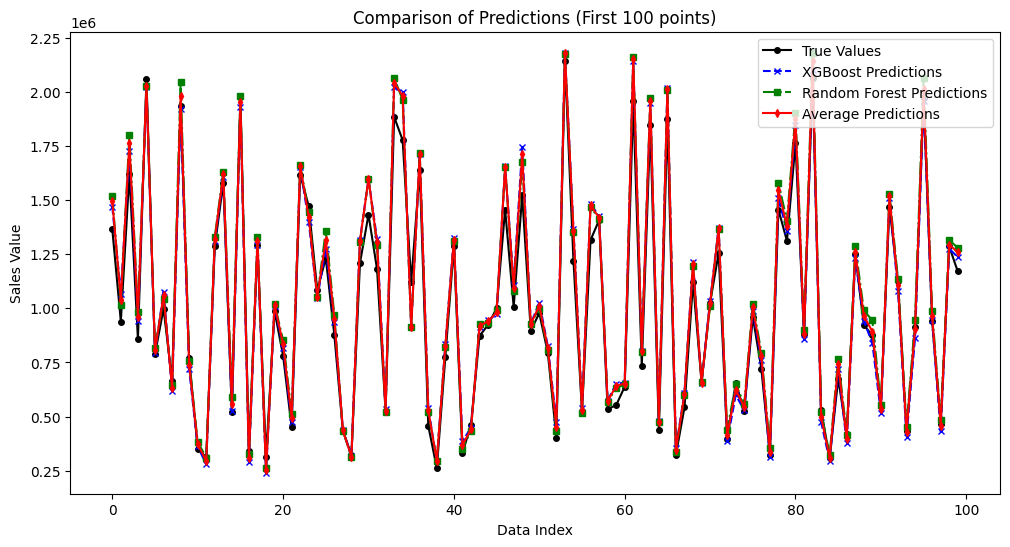

In [52]:
# Sub-sample to first 100 points for clearer visualization
x_axis = range(100)
plt.figure(figsize=(12, 6))

# Plot true values
plt.plot(x_axis, y_test.values[:100], 'k-', label="True Values", marker='o', markersize=4)

# Plot predictions from XGBoost
plt.plot(x_axis, predictions_xgb[:100], 'b--', label="XGBoost Predictions", marker='x', markersize=4)

# Plot predictions from RandomForest
plt.plot(x_axis, predictions_rf[:100], 'g-.', label="Random Forest Predictions", marker='s', markersize=4)

# Plot the average predictions
plt.plot(x_axis, final_predictions[:100], 'r-', label="Average Predictions", marker='d', markersize=4)

# Add title and labels
plt.title("Comparison of Predictions (First 100 Points)")
plt.xlabel("Data Index")
plt.ylabel("Sales Value")
plt.legend()

# Show the plot
plt.show()


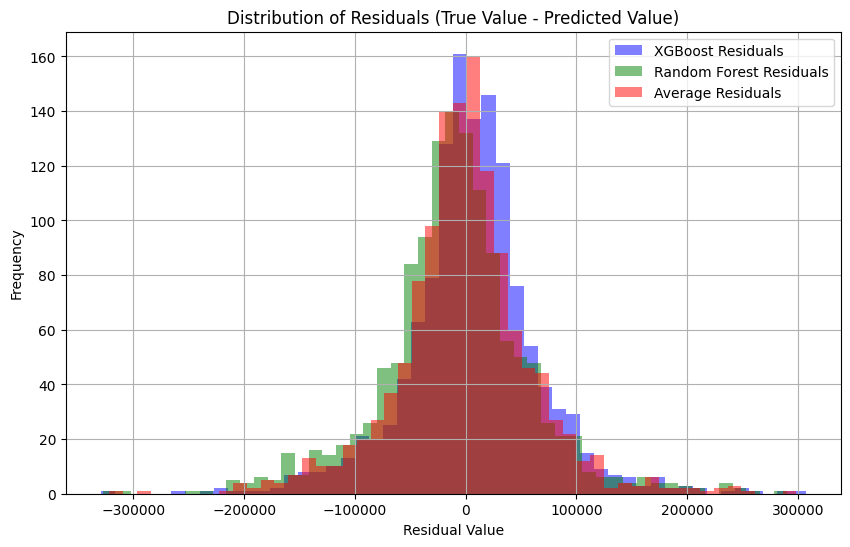

In [54]:
# Plot histogram of residuals for each model
plt.figure(figsize=(10, 6))

plt.hist(residuals_xgb, bins=50, alpha=0.5, label='XGBoost Residuals', color='blue')
plt.hist(residuals_rf, bins=50, alpha=0.5, label='Random Forest Residuals', color='green')
plt.hist(residuals_avg, bins=50, alpha=0.5, label='Average Residuals', color='red')

plt.title('Distribution of Residuals (True Value - Predicted Value)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## LSTM 

In [64]:
def create_sequences(data, time_steps=5):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :]) # Sequence of time steps
        y.append(data[i, 0]) # Predicting weekly sales (first column)
    return np.array(X), np.array(y)

scaled_data = df_train[features].values 
time_steps = 5
X, y = create_sequences(scaled_data, time_steps)

# Reshape X to fit the LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], len(features))

# Split train-test data
train_size = int(X.shape[0] * 0.8)  # Use 80% of data for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [60]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=100, return_sequences=True))
model.add(BatchNormalization())  
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
model.save('sales_lstm.keras')

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0595 - val_loss: 0.0249
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0263 - val_loss: 0.0219
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0240 - val_loss: 0.0234
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0249 - val_loss: 0.0223
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0233 - val_loss: 0.0243
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0228 - val_loss: 0.0221
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0227 - val_loss: 0.0226
Epoch 9/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0216 - val_loss: 0.0232
Epoch 10/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0213 - val_loss: 0.0230
Epoch 11/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0210 - val_loss: 0.0227
Epoch 12/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 

In [41]:
print(predictions)
print(predictions.shape)
print(predictions.size)

[[0.19731578]
 [0.18650663]
 [0.20109573]
 ...
 [0.19580099]
 [0.2130081 ]
 [0.22468108]]
(1286, 1)
1286


In [47]:
# Normalize target variable
sales_scaler = MinMaxScaler()
sales_scaler.fit(data[['Weekly_Sales']])

# Reshape the predictions for inverse transformation
predictions = predictions.reshape(-1, 1)

# Get sales prediction using inverse transform
predictions_original = sales_scaler.inverse_transform(predictions)
print(predictions_original)


[[ 922039.5 ]
 [ 883032.5 ]
 [ 935680.2 ]
 ...
 [ 916573.06]
 [ 978668.4 ]
 [1020792.6 ]]


In [48]:
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 0.14946158953432373
MAE: 0.1251104286696683
R-squared: -0.02367211661164137


In [52]:
# Rescale to compare lstm evals with regressor evals
y_test_reshaped = y_test.reshape(-1, 1)
y_test_original = sales_scaler.inverse_transform(y_test_reshaped)

rmse = mean_squared_error(y_test_original, predictions_original, squared=False)
mae = mean_absolute_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 539362.0382218289
MAE: 451486.00500583206
R-squared: -0.023672116874750904


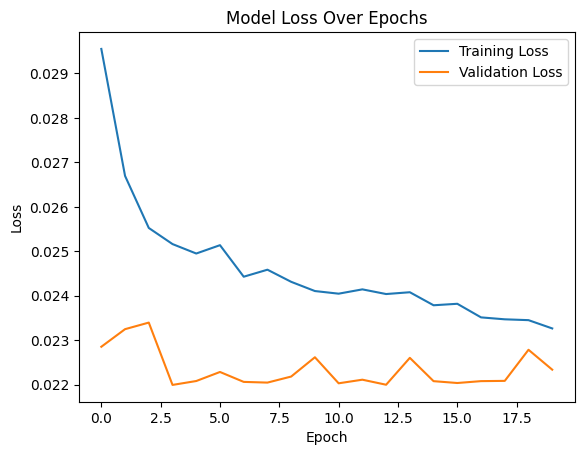

In [49]:
# Plot the training and validation loss 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## ARIMA (Autoregressive Integrated Moving Average) - Time Series Sales Forecasting for each Store

* p - autoregressing order (ACF - autocorrelation funciton)
* d - differencing
* q - moving average order (PACF - partial autocorrelation function)

In [8]:
data = pd.read_csv("/kaggle/input/walmart-sales/Walmart_Sales.csv")
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [14]:
data = pd.read_csv("/kaggle/input/walmart-sales/Walmart_Sales.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.set_index(['Store', 'Date'])
data.index = data.index.set_levels(data.index.levels[1].to_period('W-FRI'), level='Date')
data

Weekly_Sales  Holiday_Flag  Temperature  \
Store Date                                                             
1     2010-01-30/2010-02-05    1643690.90             0        42.31   
      2010-02-06/2010-02-12    1641957.44             1        38.51   
      2010-02-13/2010-02-19    1611968.17             0        39.93   
      2010-02-20/2010-02-26    1409727.59             0        46.63   
      2010-02-27/2010-03-05    1554806.68             0        46.50   
...                                   ...           ...          ...   
45    2012-09-22/2012-09-28     713173.95             0        64.88   
      2012-09-29/2012-10-05     733455.07             0        64.89   
      2012-10-06/2012-10-12     734464.36             0        54.47   
      2012-10-13/2012-10-19     718125.53             0        56.47   
      2012-10-20/2012-10-26     760281.43             0        58.85   

                             Fuel_Price         CPI  Unemployment  
Store Date                                                         
1     2010-01-30/2010-02-05       2.572  211.096358         8.106  
      2010-02-06/2010-02-12       2.548  211.242170         8.106  
      2010-02-13/2010-02-19       2.514  211.289143         8.106  
      2010-02-20/2010-02-26       2.561  211.319643         8.106  
      2010-02-27/2010-03-05       2.625  211.350143         8.106  
...                                 ...         ...           ...  
45    2012-09-22/2012-09-28       3.997  192.013558         8.684  
      2012-09-29/2012-10-05       3.985  192.170412         8.667  
      2012-10-06/2012-10-12       4.000  192.327265         8.667  
      2012-10-13/2012-10-19       3.969  192.330854         8.667  
      2012-10-20/2012-10-26       3.882  192.308899         8.667  

[6435 rows x 6 columns]

In [4]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import joblib

# Load the data
data = pd.read_csv("/kaggle/input/walmart-sales/Walmart_Sales.csv")

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Set a MultiIndex for 'Store' and 'Date'
data = data.set_index(['Store', 'Date'])

# 4. Ensure weekly frequency in the date index  
data.index = data.index.set_levels(data.index.levels[1].to_period('W-FRI'), level='Date')

# Function to train ARIMA model and save it
def train_arima(store_data, store_id):
    store_sales = store_data['Weekly_Sales']
    
    # Build and train ARIMA model (Adjust the order (p, d, q) based on ACF/PACF analysis)
    model = ARIMA(store_sales, order=(5, 1, 0))  
    arima_model = model.fit()
    
    # Save the trained model for each store
    joblib.dump(arima_model, f'arima_model_store_{store_id}.joblib')

# Function to make ARIMA predictions (forecasting)
def predict_sales_arima(store_id, steps=4):
    # Load the saved ARIMA model for the store
    model = joblib.load(f'arima_model_store_{store_id}.joblib')

    # Forecast the next 'steps' weeks
    predictions = model.forecast(steps=steps)  # Predict the next 'steps' weeks
    return predictions

# Train ARIMA model for each store
stores = data.index.get_level_values('Store').unique()

for store in stores:
    print(f"Training ARIMA for Store {store}...")  
    
    # Filter data for each store
    store_data = data.xs(store, level='Store')
    
    # Train ARIMA model for each store
    train_arima(store_data, store_id=store)

print("ARIMA training completed for all stores.")

# Predicting for Store 1 for the next 4 weeks
store_id = 1  
predicted_sales = predict_sales_arima(store_id, steps=4)  
print(f"Predicted sales for store {store_id} for the next 4 weeks:\n{predicted_sales}")


Training ARIMA for Store 1...
Training ARIMA for Store 2...
Training ARIMA for Store 3...
Training ARIMA for Store 4...
Training ARIMA for Store 5...
Training ARIMA for Store 6...
Training ARIMA for Store 7...
Training ARIMA for Store 8...
Training ARIMA for Store 9...
Training ARIMA for Store 10...
Training ARIMA for Store 11...
Training ARIMA for Store 12...
Training ARIMA for Store 13...
Training ARIMA for Store 14...
Training ARIMA for Store 15...
Training ARIMA for Store 16...
Training ARIMA for Store 17...
Training ARIMA for Store 18...
Training ARIMA for Store 19...
Training ARIMA for Store 20...
Training ARIMA for Store 21...
Training ARIMA for Store 22...
Training ARIMA for Store 23...
Training ARIMA for Store 24...
Training ARIMA for Store 25...
Training ARIMA for Store 26...
Training ARIMA for Store 27...
Training ARIMA for Store 28...
Training ARIMA for Store 29...
Training ARIMA for Store 30...
Training ARIMA for Store 31...
Training ARIMA for Store 32...
Training ARIMA fo

In [10]:
store_id = 45  
weeks = 4
predicted_sales = predict_sales_arima(store_id, steps=weeks) 

# Convert the forecast to a DataFrame for easier formatting
predicted_sales_df = predicted_sales.reset_index()
predicted_sales_df.columns = ['Date', 'Sales']

# Use the ending date for each period and format the sales to two decimal places
predicted_sales_df['Date'] = predicted_sales_df['Date'].dt.strftime('%Y-%m-%d')
predicted_sales_df['Sales'] = predicted_sales_df['Sales'].apply(lambda x: f"{x:.2f}")

# Display the result
for index, row in predicted_sales_df.iterrows():
    print(f"Date: {row['Date']}, Predicted Sales: ${row['Sales']}")

Date: 2012-11-02, Predicted Sales: $750791.40
Date: 2012-11-09, Predicted Sales: $745211.57
Date: 2012-11-16, Predicted Sales: $739952.66
Date: 2012-11-23, Predicted Sales: $750432.96


In [ ]:
import shutil
shutil.make_archive('/kaggle/working/arima_models', 'zip', '/kaggle/working')